In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
# !pip install openml
import openml
# !pip install cardinal
# !pip install scikit-learn==0.20.4
# !pip install sklearn.cluster._k_means_fast
from cardinal.uncertainty import MarginSampler
from cardinal.random import RandomSampler
from cardinal.zhdanov2019 import TwoStepKMeansSampler
from cardinal.plotting import plot_confidence_interval
import tqdm

In [2]:
np.random.seed(123)

# Accuracy Curves

## OpenML

In [3]:
dataset_id = 42750

In [204]:
dataset = openml.datasets.get_dataset(dataset_id)
X, y, cat_indicator, names = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)  #dataframe / array
cat_indicator = np.asarray(cat_indicator)


#Special preprocessing for debugging
# X=X.drop(['ID_code'], axis = 1)       #id = 42395
# X=X.drop(['brewery_name', 'review_profilename'], axis = 1)        #id = 42088
# X=X.drop(['full_name'], axis = 1)       #id = 42256
# cat_indicator = cat_indicator[1:]
# X=X.drop(['Accident_Index', 'Date','Time', 'Local_Authority_(Highway)', 'LSOA_of_Accident_Location'], axis = 1)       #id = 42803
# X=X.drop(['Gender', 'ScheduledDay', 'AppointmentDay','Neighbourhood'], axis = 1)          #43439
# X=X.drop(['brewery_name', 'review_profilename', 'beer_name'], axis = 1)      #id = 42088
# cat_indicator = cat_indicator[3:] 

# Preprocessing plus propre 

def getIndexsFeatures(X, feat):
    indexes = []
    for f in feat:
        idx = np.where(X.columns == f)
        indexes.append(idx)
    return indexes

if dataset_id == 1471 : 
    feat_to_convert_in_categorical = [] #ok
    feat_to_drop = []
elif dataset_id == 1502 : 
    feat_to_convert_in_categorical = [] #ok
    feat_to_drop = []
elif dataset_id == 40922 : 
    feat_to_convert_in_categorical = [] #ok
    feat_to_drop = []
elif dataset_id == 41162 : 
    feat_to_convert_in_categorical = [] #ok
    feat_to_drop = []
elif dataset_id == 43551 : 
    feat_to_convert_in_categorical = ['is_male', 'logical_score', 'verbal_score']
    feat_to_drop = []
elif dataset_id == 1461 : 
    feat_to_convert_in_categorical = ['V1', 'V13', 'V15']
    feat_to_drop = ['V10', 'V11']
elif dataset_id == 1590 :
    feat_to_convert_in_categorical = ['education-num', 'hours-per-week']
    feat_to_drop = []
elif dataset_id == 41138 : 
    feat_to_convert_in_categorical = ['cd_000', 'ch_000', 'ef_000'] #TODO
    feat_to_drop = []
elif dataset_id == 42395 : 
    feat_to_convert_in_categorical = [] #ok
    feat_to_drop = []
elif dataset_id == 42803 : 
    feat_to_convert_in_categorical = ['Vehicle_Reference_df_res', 'Vehicle_Type', 'Towing_and_Articulation', 'Vehicle_Manoeuvre', 'Restricted_Lane', 'Junction_Location', 'Skidding_and_Overturning', 'Hit_Object_in_Carriageway', 'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway',
'Vehicle_Leaving_Carriageway', 'Hit_Object_off_Carriageway', '1st_Point_of_Impact', 'Was_Vehicle_Left_Hand_Drive?', 'Journey_Purpose_of_Driver', 'Age_Band_of_Driver', 'Propulsion_Code','Driver_Home_Area_Type', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties',
'Day_of_Week', 'Local_Authority_(District)', '1st_Road_Class', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class','Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions' , 'Weather_Conditions' , 'Road_Surface_Conditions', 
'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident','Vehicle_Reference_df', 'Casualty_Reference', 'Casualty_Class', 'Sex_of_Casualty', 'Age_Band_of_Casualty', 'Casualty_Severity', 'Pedestrian_Location','Pedestrian_Movement', 'Car_Passenger', 'Bus_or_Coach_Passenger', 
'Pedestrian_Road_Maintenance_Worker', 'Casualty_Type', 'Casualty_Home_Area_Type', 'Casualty_IMD_Decile']
    feat_to_drop = []
elif dataset_id == 43439 : 
    feat_to_convert_in_categorical = ['Gender', 'AppointmentDay', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
    feat_to_drop = ['PatientId', 'AppointmentId']

#Modification des features catégorielles
new_cat_idx = getIndexsFeatures(X, feat_to_convert_in_categorical)
cat_indicator[new_cat_idx] = True

#Suppression de features
X=X.drop(feat_to_drop, axis = 1)
drop_idx = getIndexsFeatures(X, feat_to_drop)
cat_indicator = np.delete(cat_indicator, drop_idx)   # cat_indicator = cat_indicator[3:]



ct_cat = ColumnTransformer([
    ('normalizer', StandardScaler(), np.where(~cat_indicator)[0])
], remainder='passthrough')

X_cat = pd.DataFrame(ct_cat.fit_transform(X)).convert_dtypes()

ct = ColumnTransformer([
    ('encoder', OneHotEncoder(), np.where(cat_indicator)[0]),
    ('normalizer', StandardScaler(), np.where(~cat_indicator)[0])
], remainder='passthrough')

X = ct.fit_transform(X)

#Reduce execution time
X = X[:150000]
y = y[:150000]

y = y
X = np.asarray(np.nan_to_num(X))    #X.todense()
batch_size = int(0.01 * X.shape[0])
n_iter = 10

X.shape, y.shape, batch_size

((150000, 9), (150000,), 1500)

## Run

In [205]:
# Put a grid search CV probably

model = GradientBoostingClassifier()
model.fit(X, y)
model.score(X, y)

0.8671266666666667

100%|██████████| 3/3 [44:18:24<00:00, 53168.30s/it]   


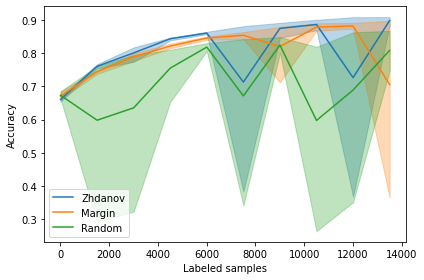

In [206]:
starting_samplers = [
    # ('KMeans', KMeansSampler(batch_size)),
    ('Random', RandomSampler(batch_size)),
]

samplers = [
    ('Zhdanov', TwoStepKMeansSampler(5, model, batch_size)),
    ('Margin', MarginSampler(model, batch_size)),
    ('Random', RandomSampler(batch_size)),
]

#figure_accuracies = plt.figure().number


for sampler_name, sampler in tqdm.tqdm(samplers):

    all_accuracies = []

    for k in tqdm.tqdm(range(5)):
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=int(.2 * X.shape[0]), random_state=k)

        accuracies = []

        # We use the starting sampler to kickstart the experiment
        selected = RandomSampler(batch_size).fit(X_train).select_samples(X_train)

        # We use binary masks to simplify some operations
        mask = np.zeros(X_train.shape[0], dtype=bool)
        indices = np.arange(X_train.shape[0])
        mask[selected] = True

        # The classic active learning loop
        for j in range(n_iter):
            model.fit(X_train[mask], y_train[mask])

            # Record metrics
            accuracies.append(model.score(X_test, y_test))

            sampler.fit(X_train[mask], y_train[mask])
            selected = sampler.select_samples(X_train[~mask])
            mask[indices[~mask][selected]] = True

        all_accuracies.append(accuracies)

    x_data = np.arange(10, batch_size * (n_iter - 1) + 11, batch_size)
    plot_confidence_interval(x_data, all_accuracies, label='{}'.format(sampler_name))


plt.xlabel('Labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()

plt.savefig(f'{dataset_id}-accuracy.png')
plt.show()

In [ ]:
print(y_test[:10])

##### Big loop

Dataset n°0: ID=40922


100%|██████████| 3/3 [08:26<00:00, 168.97s/it]


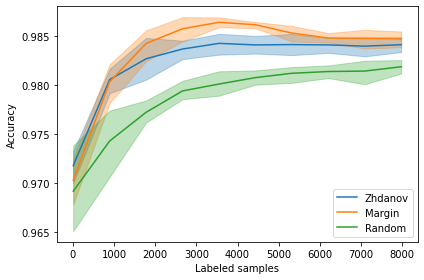

Dataset n°1: ID=42395


PyOpenMLError: PyOpenML cannot handle string when returning numpy arrays. Use dataset_format="dataframe".

In [40]:
dataset_ids = [41162]  
#DONE : 1471, 1502, 40922       \   41162, 42493, 43551, 1461, 1590, 41138, 42395, 42256, 42803, 43439
#TODO : 42088

for i, dataset_id in enumerate(dataset_ids):
    print(f"Dataset n°{i}: ID={dataset_id}")

    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, cat_indicator, names = dataset.get_data(dataset_format='array', target=dataset.default_target_attribute)
    cat_indicator = np.asarray(cat_indicator)

    ct_cat = ColumnTransformer([
        ('normalizer', StandardScaler(), np.where(~cat_indicator)[0])
    ], remainder='passthrough')

    X_cat = pd.DataFrame(ct_cat.fit_transform(X)).convert_dtypes()

    ct = ColumnTransformer([
        ('encoder', OneHotEncoder(), np.where(cat_indicator)[0]),
        ('normalizer', StandardScaler(), np.where(~cat_indicator)[0])
    ], remainder='passthrough')

    X = ct.fit_transform(X)

    y = y
    X = np.asarray(np.nan_to_num(X))    #X.todense()
    batch_size = int(0.01 * X.shape[0])
    n_iter = 10

    X.shape, y.shape, batch_size



    # Put a grid search CV probably

    model = GradientBoostingClassifier()
    model.fit(X, y)
    model.score(X, y)



    starting_samplers = [
        # ('KMeans', KMeansSampler(batch_size)),
        ('Random', RandomSampler(batch_size)),
    ]

    samplers = [
        ('Zhdanov', TwoStepKMeansSampler(5, model, batch_size)),
        ('Margin', MarginSampler(model, batch_size)),
        ('Random', RandomSampler(batch_size)),
    ]

    #figure_accuracies = plt.figure().number


    for sampler_name, sampler in tqdm.tqdm(samplers):

        all_accuracies = []

        for k in tqdm.tqdm(range(5)):
            X_train, X_test, y_train, y_test = \
                train_test_split(X, y, test_size=int(.2 * X.shape[0]), random_state=k)

            accuracies = []

            # We use the starting sampler to kickstart the experiment
            selected = RandomSampler(batch_size).fit(X_train).select_samples(X_train)

            # We use binary masks to simplify some operations
            mask = np.zeros(X_train.shape[0], dtype=bool)
            indices = np.arange(X_train.shape[0])
            mask[selected] = True

            # The classic active learning loop
            for j in range(n_iter):
                model.fit(X_train[mask], y_train[mask])

                # Record metrics
                accuracies.append(model.score(X_test, y_test))

                sampler.fit(X_train[mask], y_train[mask])
                selected = sampler.select_samples(X_train[~mask])
                mask[indices[~mask][selected]] = True

            all_accuracies.append(accuracies)

        x_data = np.arange(10, batch_size * (n_iter - 1) + 11, batch_size)
        plot_confidence_interval(x_data, all_accuracies, label='{}'.format(sampler_name))


    plt.xlabel('Labeled samples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    plt.savefig(f'{dataset_id}-accuracy.png')
    plt.show()

In [ ]:
dataset_id = 41138

In [ ]:
dataset = openml.datasets.get_dataset(dataset_id)
X, y, cat_indicator, names = dataset.get_data(dataset_format='dataframe', target=dataset.default_target_attribute)  #dataframe / array
cat_indicator = np.asarray(cat_indicator)

ct_cat = ColumnTransformer([
    ('normalizer', StandardScaler(), np.where(~cat_indicator)[0])
], remainder='passthrough')

X_cat = pd.DataFrame(ct_cat.fit_transform(X)).convert_dtypes()

ct = ColumnTransformer([
    ('encoder', OneHotEncoder(), np.where(cat_indicator)[0]),
    ('normalizer', StandardScaler(), np.where(~cat_indicator)[0])
], remainder='passthrough')

# print(X.shape)
X = ct.fit_transform(X)
# print(X.shape)

y = y
X = np.asarray(np.nan_to_num(X))    #X.todense()
batch_size = int(0.01 * X.shape[0])
n_iter = 10

X.shape, y.shape, batch_size